In [ ]:
!wget https://raw.githubusercontent.com/iabufarha/iSarcasmEval/main/train/train.En.csv
!wget https://raw.githubusercontent.com/iabufarha/iSarcasmEval/main/test/task_A_En_test.csv

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf 

In [ ]:
df = pd.read_csv('/content/train.En.csv')
df_test = pd.read_csv('/content/task_A_En_test.csv')
df_train = df 
df.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df=df.dropna(subset=['tweet'])
df_test=df_test.dropna(subset=['text'])

<Axes: ylabel='count'>

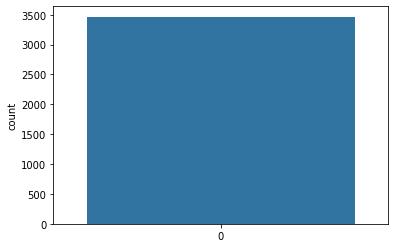

In [ ]:
sns.countplot(df['sarcastic'])

#### Len of tweets

(array([291., 716., 603., 456., 201., 123.,  90.,  98.,  20.,   2.]),
 array([  2. ,  38.3,  74.6, 110.9, 147.2, 183.5, 219.8, 256.1, 292.4,
        328.7, 365. ]),
 <BarContainer object of 10 artists>)

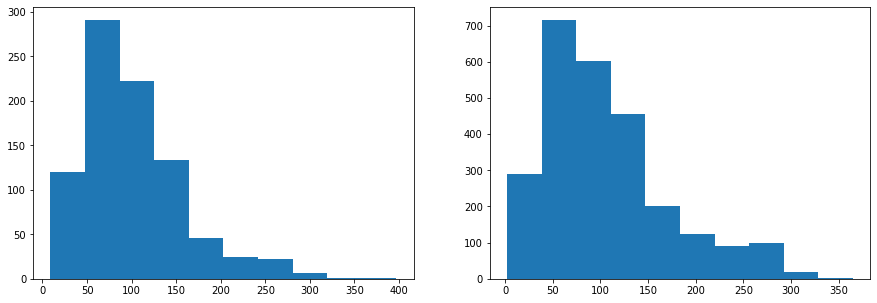

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(df[df['sarcastic']==1]['tweet'].str.len())
ax[1].hist(df[df['sarcastic']==0]['tweet'].str.len())

(array([262., 637., 581., 444., 274., 155., 100.,  81.,  50.,  16.]),
 array([ 1.,  7., 13., 19., 25., 31., 37., 43., 49., 55., 61.]),
 <a list of 10 Patch objects>)

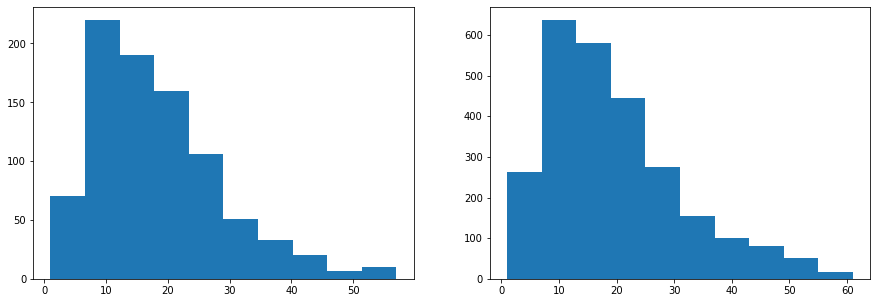

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(df[df['sarcastic']==1]['tweet'].str.split().map(lambda x: len(x)))
ax[1].hist(df[df['sarcastic']==0]['tweet'].str.split().map(lambda x: len(x)))

### Frequency Tokenization

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tokens = df['tweet'].apply(lambda x: ' '.join([val for val in word_tokenize(x.lower()) if val not in stop_words])).values
tokens_test = df_test['text'].apply(lambda x: ' '.join([val for val in word_tokenize(x.lower()) if val not in stop_words])).values

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
xtrain_bow = bow_vectorizer.fit_transform(tokens)
xtest_bow = bow_vectorizer.transform(tokens_test)

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
xtrain_tfidf = tfidf_vectorizer.fit_transform(tokens)
xtest_tfidf= tfidf_vectorizer.transform(tokens_test)

In [ ]:
xtrain_tfidf.shape, xtest_tfidf.shape

((3467, 1000), (1400, 1000))

### Word2Vec

In [ ]:
tokens = [val.split() for val in tokens]
tokens_test = [val.split() for val in tokens_test]

In [ ]:
len(tokens), len(tokens_test)

(3467, 1400)

In [ ]:
import gensim

w2v_model = gensim.models.Word2Vec(
            tokens,
            vector_size=300, # desired no. of features/independent variables
            window=5, # context window size
            min_count=0, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            seed = 42)

w2v_model.train(tokens, total_examples= len(tokens), epochs=30)

(1184824, 1376250)

In [ ]:
w2v_model.init_sims(replace=True)

<ipython-input-25-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [ ]:
words = set(w2v_model.wv.index_to_key)
xtrain_w2v = np.array([np.mean(np.nan_to_num(np.array([w2v_model.wv[i] if i in words else np.zeros((300,)) for i in ls], dtype=object)), axis=0)
                         for ls in tokens], dtype=object)
xtest_w2v = np.array([np.mean(np.nan_to_num(np.array([w2v_model.wv[i] if i in words else np.zeros((300,)) for i in ls ], dtype=object)), axis=0)
                         for ls in tokens_test], dtype=object)

In [ ]:
xtrain_w2v.shape, xtest_w2v.shape

((3467, 300), (1400, 300))

### GLoVe

In [ ]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2023-03-22 19:01:11--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2023-03-22 19:01:12--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G   973KB/s    in 6m 5s   

2023-03-22 19:07:18 (3.97 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27

In [ ]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip.1
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
EMBEDDING_FILE = './glove.twitter.27B.200d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
x_train = df['tweet'].values
y_train = df['sarcastic'].values
x_test = df_test['text'].values
y_test = df_test['sarcastic'].values

In [ ]:
max_features = 35000
maxlen = 200

from keras.utils import pad_sequences

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
print(embedding_matrix.shape)

(11386, 200)


In [ ]:
np.save('embedding_matrix.npy', embedding_matrix)

### **LSTM with GloVe**

In [ ]:
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.models import Model

vocab_len = len(word_index)
emb_dim = 200

embedding_layer = Embedding(vocab_len,
                            maxlen,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                             trainable=False)

#Bi-LSTM
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(emb_dim, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(emb_dim,)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

'''
#LSTM
model = Sequential([
    embedding_layer,
    LSTM(emb_dim, return_sequences=True),
    Dropout(0.5),
    LSTM(emb_dim,),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())
'''

'''


#Option 2

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, input_len = maxlen, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          2277200   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 400)         641600    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200, 400)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              961600    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1)                 4

"\n\n\n#Option 2\n\nlstm_model = Sequential()\nlstm_model.add(Embedding(vocab_len, emb_dim, input_len = maxlen, trainable = False, weights=[embedding_matrix]))\nlstm_model.add(LSTM(128, return_sequences=False))\nlstm_model.add(Dropout(0.5))\nlstm_model.add(Dense(1, activation = 'sigmoid'))\nlstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nprint(lstm_model.summary())\n"

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10)#, validation_data=(X_test, y_test))

Epoch 1/10
55/55 [==============================] - 42s 76ms/step - loss: 0.5815 - accuracy: 0.7456
Epoch 2/10
55/55 [==============================] - 4s 75ms/step - loss: 0.5615 - accuracy: 0.7505
Epoch 3/10
55/55 [==============================] - 4s 75ms/step - loss: 0.5419 - accuracy: 0.7511
Epoch 4/10
55/55 [==============================] - 4s 75ms/step - loss: 0.5230 - accuracy: 0.7603
Epoch 5/10
55/55 [==============================] - 4s 77ms/step - loss: 0.5005 - accuracy: 0.7690
Epoch 6/10
55/55 [==============================] - 4s 76ms/step - loss: 0.4685 - accuracy: 0.7871
Epoch 7/10
55/55 [==============================] - 4s 76ms/step - loss: 0.4182 - accuracy: 0.8105
Epoch 8/10
55/55 [==============================] - 4s 77ms/step - loss: 0.3482 - accuracy: 0.8431
Epoch 9/10
55/55 [==============================] - 4s 76ms/step - loss: 0.3041 - accuracy: 0.8702
Epoch 10/10
55/55 [==============================] - 4s 76ms/step - loss: 0.2340 - accuracy: 0.8973


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred1 = [1 if prob > 0.5 else 0 for prob in y_pred]

# Print f1, precision, and recall scores
print(precision_score(y_test, y_pred1 , average="macro"))
print(recall_score(y_test, y_pred1 , average="macro"))
print(f1_score(y_test, y_pred1 , average="binary"))
print(confusion_matrix(y_pred1, y_test))
print(classification_report(y_test, y_pred1))

44/44 [==============================] - 1s 23ms/step
0.5429434131066876
0.52
0.13333333333333333
[[1134  181]
 [  66   19]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1200
           1       0.22      0.10      0.13       200

    accuracy                           0.82      1400
   macro avg       0.54      0.52      0.52      1400
weighted avg       0.77      0.82      0.79      1400



### **Bidirectional GRUs with Attention**

In [ ]:
from tensorflow.keras.layers import Layer
from keras import backend as K


class AttentionLayer(keras.layers.Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
GRU_DIM = 128

inp = keras.layers.Input(shape=(maxlen,))
x = keras.layers.Embedding(vocab_len, emb_dim, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x)
x = AttentionLayer(maxlen)(x)
x = keras.layers.Dense(GRU_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs=inp, outputs=outp)

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 200, 200)          2277200   
                                                                 
 bidirectional_5 (Bidirectio  (None, 200, 256)         253440    
 nal)                                                            
                                                                 
 attention_layer_2 (Attentio  (None, 256)              456       
 nLayer)                                                         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0   

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10)#, validation_data=(X_test, y_test))

Epoch 1/10
55/55 [==============================] - 8s 24ms/step - loss: 0.5785 - accuracy: 0.7395
Epoch 2/10
55/55 [==============================] - 1s 22ms/step - loss: 0.5632 - accuracy: 0.7499
Epoch 3/10
55/55 [==============================] - 1s 22ms/step - loss: 0.5253 - accuracy: 0.7609
Epoch 4/10
55/55 [==============================] - 2s 27ms/step - loss: 0.3121 - accuracy: 0.8820
Epoch 5/10
55/55 [==============================] - 2s 28ms/step - loss: 0.2096 - accuracy: 0.9302
Epoch 6/10
55/55 [==============================] - 1s 24ms/step - loss: 0.1038 - accuracy: 0.9691
Epoch 7/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0506 - accuracy: 0.9859
Epoch 8/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0273 - accuracy: 0.9931
Epoch 9/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0276 - accuracy: 0.9951
Epoch 10/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0204 - accuracy: 0.9965


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred1 = [1 if prob > 0.5 else 0 for prob in y_pred]

print(f1_score(y_test, y_pred1 , average="binary"))
print(classification_report(y_test, y_pred1))

44/44 [==============================] - 1s 10ms/step
0.264069264069264
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1200
           1       0.23      0.30      0.26       200

    accuracy                           0.76      1400
   macro avg       0.56      0.57      0.56      1400
weighted avg       0.79      0.76      0.77      1400



### **Stacked LSTM**

In [ ]:
LSTM_DIM = 128

inp = keras.layers.Input(shape=(maxlen,))
x = keras.layers.Embedding(vocab_len, emb_dim, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(LSTM_DIM*2, return_sequences=True))(x)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(LSTM_DIM, return_sequences=True))(x)
x = AttentionLayer(maxlen)(x)
x = keras.layers.Dense(LSTM_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(LSTM_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)

model2 = keras.models.Model(inputs=inp, outputs=outp)
    
model2.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model2.summary()

In [ ]:
history = model2.fit(x_train, y_train, batch_size=64, epochs=7)

Epoch 1/7
55/55 [==============================] - 6s 61ms/step - loss: 0.5747 - accuracy: 0.7416
Epoch 2/7
55/55 [==============================] - 3s 61ms/step - loss: 0.5684 - accuracy: 0.7499
Epoch 3/7
55/55 [==============================] - 3s 61ms/step - loss: 0.4576 - accuracy: 0.7894
Epoch 4/7
55/55 [==============================] - 3s 60ms/step - loss: 0.2250 - accuracy: 0.9233
Epoch 5/7
55/55 [==============================] - 3s 61ms/step - loss: 0.1039 - accuracy: 0.9738
Epoch 6/7
55/55 [==============================] - 3s 61ms/step - loss: 0.0618 - accuracy: 0.9847
Epoch 7/7
55/55 [==============================] - 3s 61ms/step - loss: 0.0595 - accuracy: 0.9873


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred1 = [1 if prob > 0.5 else 0 for prob in y_pred]

print(f1_score(y_test, y_pred1 , average="binary"))
print(classification_report(y_test, y_pred1))

44/44 [==============================] - 0s 9ms/step
0.27180527383367137
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1200
           1       0.23      0.34      0.27       200

    accuracy                           0.74      1400
   macro avg       0.55      0.57      0.56      1400
weighted avg       0.79      0.74      0.76      1400



### **SVM with TF-IDF**

In [ ]:
from sklearn.svm import SVC 
from sklearn.metrics import f1_score

clf = SVC(kernel='rbf', degree=3)
clf.fit(xtrain_tfidf, y_train)

# predict and evaluate predictions
y_pred_svm = clf.predict(xtest_tfidf)

y_pred_svm1 = [1 if prob > 0.5 else 0 for prob in y_pred_svm]

print("F1-Score: SVM with tfidf:", f1_score(y_test, y_pred_svm1 , average="binary"))

F1-Score: SVM with tfidf: 0.06140350877192982


### Logistic Regression, Random Forest, XGB

In [ ]:
y_train = df['sarcastic'].values
y_test = df_test['sarcastic'].values
y_train.shape, y_test.shape

((3467,), (1400,))

#### **ML Methods with Word2Vec**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from xgboost import XGBClassifier
import xgboost as xgb

rf = RandomForestClassifier(class_weight='balanced_subsample')
grid_rf = GridSearchCV(rf, {'n_estimators':[300,500,700], 'max_depth':[5,7,11]})

xgb_classifier = XGBClassifier()
grid_xgb = GridSearchCV(xgb_classifier, {'n_estimators':[300,500,700], 
                                         'max_depth':[5,7,11]})

lr = LogisticRegressionCV(max_iter=1000)

lr_model = lr.fit(xtrain_w2v, y_train)
rf_model = grid_rf.fit(xtrain_w2v, y_train)
xgb_model = grid_xgb.fit(xtrain_w2v, y_train)

y_pred_lr = lr_model.predict(xtest_w2v)
y_pred_rf = rf_model.predict(xtest_w2v)
y_pred_xgb = xgb_model.predict(xtest_w2v)

y_pred_lr1 = [1 if prob > 0.5 else 0 for prob in y_pred_lr]
y_pred_rf1 = [1 if prob > 0.5 else 0 for prob in y_pred_rf]
y_pred_xgb1 = [1 if prob > 0.5 else 0 for prob in y_pred_xgb]

print("F1-Score: LR with Word2Vec:", f1_score(y_test, y_pred_lr1 , average="binary"))
print("F1-Score: RF with Word2Vec:", f1_score(y_test, y_pred_rf1 , average="binary"))
print("F1-Score: XGB with Word2Vec:", f1_score(y_test, y_pred_xgb1 , average="binary"))


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

F1-Score: LR with Word2Vec: 0.0
F1-Score: RF with Word2Vec: 0.047393364928909956
F1-Score: XGB with Word2Vec: 0.09649122807017543


In [ ]:
rf_model.best_params_

{'max_depth': 11, 'n_estimators': 700}

In [ ]:
print(f'Accuracy RF: {round(np.mean(y_pred_rf==y_test), 3)}')
print(f'Accuracy LR: {round(np.mean(y_pred_lr==y_test), 3)}')
print(f'Accuracy XGB: {round(np.mean(y_pred_xgb==y_test), 3)}')

Accuracy RF: 0.845
Accuracy LR: 0.856
Accuracy XGB: 0.834


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn import utils
import sklearn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#### **ML Methods with TFIDF**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import xgboost as xgb

rf = RandomForestClassifier(class_weight='balanced_subsample')
grid_rf = GridSearchCV(rf, {'n_estimators':[300,700], 'max_depth':[7,11]})

xgb_classifier = XGBClassifier()
grid_xgb = GridSearchCV(xgb_classifier, {'n_estimators':[500,700], 
                                         'max_depth':[7,11]})

lr = LogisticRegressionCV(max_iter=1000)

lr_model = lr.fit(xtrain_tfidf, y_train)
rf_model = grid_rf.fit(xtrain_tfidf, y_train)
xgb_model = grid_xgb.fit(xtrain_tfidf, y_train)

y_pred_lr = lr_model.predict(xtest_tfidf)
y_pred_rf = rf_model.predict(xtest_tfidf)
y_pred_xgb = xgb_model.predict(xtest_tfidf)

#print(f'Accuracy RF: {round(np.mean(y_pred_rf==y_test), 3)}')
#print(f'Accuracy LR: {round(np.mean(y_pred_lr==y_test), 3)}')
#print(f'Accuracy XGB: {round(np.mean(y_pred_xgb==y_test), 3)}')


y_pred_lr1 = [1 if prob > 0.5 else 0 for prob in y_pred_lr]
y_pred_rf1 = [1 if prob > 0.5 else 0 for prob in y_pred_rf]
y_pred_xgb1 = [1 if prob > 0.5 else 0 for prob in y_pred_xgb]

print("F1-Score: LR with tfidf:", f1_score(y_test, y_pred_lr1 , average="binary"))
print("F1-Score: RF with tfidf:", f1_score(y_test, y_pred_rf1 , average="binary"))
print("F1-Score: XGB with tfidf:", f1_score(y_test, y_pred_xgb1 , average="binary"))


F1-Score: LR with tfidf: 0.0
F1-Score: RF with tfidf: 0.3682170542635659
F1-Score: XGB with tfidf: 0.30466830466830463


In [ ]:
print(classification_report(y_test, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1200
           1       0.30      0.47      0.37       200

    accuracy                           0.77      1400
   macro avg       0.60      0.65      0.61      1400
weighted avg       0.82      0.77      0.79      1400



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import xgboost as xgb

#rf = RandomForestClassifier(class_weight='balanced_subsample', max_depth=11, n_estimators=300)

xgb_classifier = XGBClassifier(max_depth=11, n_estimators=500)
#grid_xgb = GridSearchCV(xgb_classifier, {'n_estimators':[500,700], 
#                                        'max_depth':[7,11]})

#lr = LogisticRegressionCV(max_iter=1000)

#lr_model = lr.fit(xtrain_tfidf, y_train)
#rf.fit(xtrain_tfidf, y_train)
xgb_classifier.fit(xtrain_tfidf, y_train)

#y_pred_lr = lr_model.predict(xtest_tfidf)
#y_pred_rf = rf.predict(xtest_tfidf)
y_pred_xgb = xgb_classifier.predict(xtest_tfidf)

#print(f'Accuracy RF: {round(np.mean(y_pred_rf==y_test), 3)}')
#print(f'Accuracy LR: {round(np.mean(y_pred_lr==y_test), 3)}')
#print(f'Accuracy XGB: {round(np.mean(y_pred_xgb==y_test), 3)}')


#y_pred_lr1 = [1 if prob > 0.5 else 0 for prob in y_pred_lr]
#y_pred_rf1 = [1 if prob > 0.5 else 0 for prob in y_pred_rf]
y_pred_xgb1 = [1 if prob > 0.5 else 0 for prob in y_pred_xgb]

#print("F1-Score: LR with tfidf:", f1_score(y_test, y_pred_lr1 , average="binary"))
#print("F1-Score: RF with tfidf:", f1_score(y_test, y_pred_rf1 , average="binary"))
print("F1-Score: XGB with tfidf:", f1_score(y_test, y_pred_xgb1 , average="binary"))


F1-Score: XGB with tfidf: 0.27895981087470445


In [ ]:
print(grid_rf.best_params_)

{'max_depth': 11, 'n_estimators': 300}


#### **ML Methods with BOW**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from xgboost import XGBClassifier
import xgboost as xgb

rf = RandomForestClassifier(class_weight='balanced_subsample')
grid_rf = GridSearchCV(rf, {'n_estimators':[300,700], 'max_depth':[7,11]})

xgb_classifier = XGBClassifier()
grid_xgb = GridSearchCV(xgb_classifier, {'n_estimators':[500,700], 
                                         'max_depth':[7,11]})

lr = LogisticRegressionCV(max_iter=1000)

lr_model = lr.fit(xtrain_bow, y_train)
rf_model = grid_rf.fit(xtrain_bow, y_train)
xgb_model = grid_xgb.fit(xtrain_bow, y_train)

y_pred_lr = lr_model.predict(xtest_bow)
y_pred_rf = rf_model.predict(xtest_bow)
y_pred_xgb = xgb_model.predict(xtest_bow)

#print(f'Accuracy RF: {round(np.mean(y_pred_rf==y_test), 3)}')
#print(f'Accuracy LR: {round(np.mean(y_pred_lr==y_test), 3)}')
#print(f'Accuracy XGB: {round(np.mean(y_pred_xgb==y_test), 3)}')

y_pred_lr1 = [1 if prob > 0.5 else 0 for prob in y_pred_lr]
y_pred_rf1 = [1 if prob > 0.5 else 0 for prob in y_pred_rf]
y_pred_xgb1 = [1 if prob > 0.5 else 0 for prob in y_pred_xgb]

print("F1-Score: LR with BOW:", f1_score(y_test, y_pred_lr1 , average="binary"))
print("F1-Score: RF with BOW:", f1_score(y_test, y_pred_rf1 , average="binary"))
print("F1-Score: XGB with BOW:", f1_score(y_test, y_pred_xgb1 , average="binary"))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1-Score: LR with BOW: 0.03902439024390244
F1-Score: RF with BOW: 0.3605313092979127
F1-Score: XGB with BOW: 0.3064935064935065
